In [2]:
import torch
import pyro
from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.special as special
import math

import os.path as path
from datetime import datetime
import json

import utils

In [3]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [4]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly
nclusters = 14                      # Try clustering down to how many clusters?

# A Cognitive Model or Harmonic Types

## Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\lambda \sim \text{Gamma}(3,1)$
- choose $\theta_c \sim \text{Beta}(1,1)$ for each of $n_\text{clusters}$ clusters
- for each chord type $c$:
  - choose $\xi_c \sim \text{Categorical}(n_\text{clusters})$
  - choose $\vec\phi_{ct}^{(c)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(c)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta_{\xi_c})$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta_{\xi_c} \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta_{\xi_c}) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta_{\xi_c} \vec\phi_{ct}^{(h)} + (1-\theta_{\xi_c}) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

In [5]:
def chord_model(npcs, nharmonies, cluster_assignment, data, subsamples=500, pobserve=0.5, **kwargs):    
    nclusters = max(cluster_assignment) + 1
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # each cluster 
    with pyro.plate('clusters', nclusters) as ind:
        # distribution of ornament probability
        p_is_chordtone = pyro.sample('p_is_chordtone', Beta(1,1))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        #cluster = pyro.sample('cluster', Categorical(torch.ones(nclusters)))
        cluster = cluster_assignment[ind]
        p_is_chordtone_c = p_is_chordtone[cluster]
        #print(p_is_chordtone.shape)
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        #p_ct = p_is_chordtone_c       * p_chordtones
        #p_or = (1 - p_is_chordtone_c) * p_ornaments
        p_ct = torch.mm(torch.diag(p_is_chordtone_c), p_chordtones)
        p_or = torch.mm(torch.diag(1 - p_is_chordtone_c), p_ornaments)
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    nchords = len(data['c'])
    subs = min(nchords,subsamples) if subsamples != None else None
    with pyro.plate('data', nchords, subsample_size=subs) as ind:
        # pick a harmony
        c = pyro.sample('c', Categorical(p_harmony), obs=data['c'][ind])
        # pick a number of notes
        nnotes = 1 + pyro.sample('n', Poisson(rate_notes), obs=data['n'][ind]).int()
        # sample chordtones
        # Normally we would sample nnotes notes for each chord, but that doesn't work vectorized.
        # However, evaluating the probability ignores n, so we can just provide 1 here.
        notes = pyro.sample('chord', Multinomial(1, p_tones[c], validate_args=False), obs=data['notes'][ind])
        chords = {'c': c,
                  'n': nnotes,
                  'counts': notes.reshape(-1,npcs)}
    return chords

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [6]:
def chord_guide(npcs, nharmonies, cluster_assignment, data, subsamples=500, pobserve=0.5, init=dict()):
    nclusters = max(cluster_assignment) + 1
    
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony',
                                  init['harmonies'] if 'harmonies' in init else 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies (parameters)
    params_p_chordtones = pyro.param('params_p_chordtones',
                                     init['chordtones'] if  'chordtones' in init else 0.5 * torch.ones(nharmonies, npcs),
                                     constraint=constraints.positive)
    params_p_ornaments = pyro.param('params_p_ornaments',
                                     init['ornaments'] if 'ornaments' in init else 0.5 * torch.ones(nharmonies, npcs),
                                    constraint=constraints.positive)
    
    # posterior of ornament probability (parameters)
    alpha_p_ict = pyro.param('alpha_p_ict',
                             init['is_ct'] if 'is_ct' in init else torch.ones(nclusters),
                             constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict',
                            init['is_or'] if 'is_or' in init else torch.ones(nclusters),
                            constraint=constraints.positive)
    
    #params_cluster = pyro.param('params_cluster', 
    #                      init['cluster'] if 'cluster' in init else
    #                      torch.ones(nharmonies, nclusters)/nclusters,
    #                      constraint = constraints.simplex)
    
    with pyro.plate('clusters', nclusters) as ind:
        pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
        
    # posteriors of ornament probability and note distributions
    with pyro.plate('harmonies', nharmonies) as ind:
    #    pyro.sample('cluster', Categorical(params_cluster))
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    #posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes',
                                  init['sum_chords'] if 'sum_chords' in init else torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes',
                                 init['n_chords'] if 'n_chords' in init else torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))

## Data and Conditioning

### Data Format

The input data (i.e. the observations that the model is conditioned on) is represented by three tensors:
- `c` for the chord labels (as "categorical" integers)
- `n` for the number of notes in each chord
- `notes` for the observed notes in each chord

Each of these tensors represents the values for all chords at the same time (i.e. a *vectorized* representation),
so the first dimension of each equals `nchords`, the number of chords.
`c` and `n` are vectors, i.e. their value for each chord is a scalar.
`notes` represents a vector for each chord that contains the counts of all pitch $\times$ note type pairs in the chord.
If we assume 29 pitch classes, we therefore have 87 entries: 29 for the chordtones, 29 for the ornaments, and 29 for the notes of unknown type.
As a result, `notes` has dimension `nchords` $\times$ 87.

The values of `c` represent each chord's type, which is distributed according to a categorical distribution.
In pyro/torch, categories are represented as integers, so we must convert textual labels into integers.
Similarly, the index of a note in `notes` is determined by it's pitch class and type (as outlined above).
While we allow negative pitch classes, they can be easily transformed into indices (and *vice versa*) by shifting all values by `npcs // 2`.

In [7]:
def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((3, npcs))
    for (fifth, t) in notes:
        chord[notetype[t], utils.fifth_to_index(fifth)] += 1
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = torch.cat([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords])
    obs["n"] = torch.tensor([len(c['notes']) - 1. for c in chords])
    return obs

### Loading the Dataset

The data is loaded from a TSV file that.
The resulting dataframe is converted to the observation format that we pass to the model.

In [8]:
def load_dataset(filename):
    print("loading dataset...") 
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)
    
    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn)
    else:
        print('extracting chords...')
        chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
                  for (_, label), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = annot_data_obs(chords)
        torch.save(obs, prefn)
    
    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [53]:
def clust_dist(X,Y):
    return 1 - (special.beta((X[0] + Y[0]) / 2, (X[1] + Y[1]) /2)) / math.sqrt(special.beta(X[0],X[1]) * special.beta(Y[0],Y[1]))

def mean_dist(X,Y):
    return abs(stats.beta.mean(X[0],X[1]) - stats.beta.mean(Y[0],Y[1]))

def kl_dist(X,Y):
    return []
        
#dist = mean_dist

def get_init_params(df, nharms, npcs, nclusters, dist):
    init = dict()
    
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False)) + 0.5

    init['chordtones'] = torch.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='chordtone'].groupby(['numlabel','fifth']):
        init['chordtones'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    init['ornaments'] = torch.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='ornament'].groupby(['numlabel','fifth']):
        init['ornaments'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()
    
    is_ct_harms = torch.tensor([sum(df[df.numlabel==l].type=='chordtone') for l in range(nharms)])
    #torch.tensor(sum(df.type=='chordtone') + 1)
    is_or_harms = torch.tensor([sum(df[df.numlabel==l].type=='ornament') for l in range(nharms)])
    #torch.tensor(sum(df.type=='ornament') + 1)
    # Do cluster assignment
    cluster_assignment = dict((k,k) for k in range(nharms))
    clusters = dict((k,(is_ct_harms[k], is_or_harms[k])) for k in range(nharms))
    for it in range(nharms - nclusters):
        # compute pairwise distances
        cs = list(clusters.items())
        n = len(cs)
        dists = dict()
        for i in range(n):
            for j in range(i+1,n):
                dists[(cs[i][0],cs[j][0])] = dist(cs[i][1], cs[j][1])

        # find minimal pair
        min1, min2 = min(dists, key=dists.get)
        # merge pair
        new_key = min1
        new_cluster = (clusters[min1][0] + clusters[min2][0],
                       clusters[min1][1] + clusters[min2][1])
        clusters.pop(min1)
        clusters.pop(min2)
        clusters[new_key] = new_cluster
        cluster_assignment = dict((k, new_key if v in [min1,min2] else v) for k,v in cluster_assignment.items())
    

    #assignment_keys = list(set(cluster_assignment.values()))
    name_mapping = dict(enumerate(clusters.keys()))
    name_mapping_inv = dict((k,v) for v,k in name_mapping.items())
    #points = list(clusters.values()) + list(zip(is_ct_harms,is_or_harms))
    #maxdist = max([dist(x,y) for x in points for y in points]) 
    #print(maxdist)
#    cluster = torch.zeros([nharms, nclusters])    
    cluster_assignment_renamed = torch.tensor([name_mapping_inv[cluster_assignment[h]]  for h in range(nharms)])
#    for chord in range(nharms):
#        cluster_assignment[chord] = name_mapping_inv[cluster_assignment[chord]]
#        dists = [dist(clusters[name_mapping[clr]], (is_ct_harms[chord], is_or_harms[chord])) for clr in range(nclusters)]
#        maxdist = max(dists)
#        print(maxdist)
#        for clr in range(nclusters):
#            cluster[chord, clr] = (maxdist - dists[clr])**2
#        cluster[chord] = cluster[chord]/(cluster[chord].sum())
    
    
    # Estimate cluster parameters
    init['is_ct'] = torch.tensor([clusters[name_mapping[i]][0] for i in range(nclusters)])
    init['is_or'] = torch.tensor([clusters[name_mapping[i]][1] for i in range(nclusters)])#torch.tensor(list(map(lambda i: i[1][1], clusters.items())))
#    init['cluster'] = cluster
    
    chord_sizes = df.groupby('chordid').size()-1
    init['sum_chords'] = torch.tensor(sum(chord_sizes) + 3)
    init['n_chords'] = torch.tensor(len(chord_sizes) + 1)
    return init, cluster_assignment_renamed

After inferring the parameters we save them for easier inspection and reuse.

In [10]:
def save_params(params, chordtypes, name):
    torch.save(params, name+'.pt')
    with open(name+'.json', 'w') as f:
        json.dump({'params': {key: val.tolist() for key,val in params.items()},
                   'chordtypes': chordtypes},
                  f)

## Inference

Inference of the posterior is done via variational inference, i.e. by optimizing the parameters of the guide.
The function `infer_posteriors` takes a dataset of observations,
performs the optimization, and returns the optimized parameters together with some of their histories.

In [ ]:
def infer_posteriors(obs, init, chordtypes, cluster_assignment,
                     nsteps=5_000, subsamples=10_000, particles=1,
                     plot_loss=True, save_as=None):
    # optimize the parameters of the guide
    pyro.clear_param_store()
    pyro.set_rng_seed(1625) # set every time for independent reproducibility
    svi = pyro.infer.SVI(model=chord_model,
                         guide=chord_guide,
                         optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999)}),
                         #optim=pyro.optim.Adadelta({"lr": 1.0, "rho": 0.9}),
                         #optim=pyro.optim.SGD({"lr": 0.00005, "momentum": 0.9, "nesterov": True}),
                         loss=pyro.infer.Trace_ELBO(num_particles=particles))

    nharms = len(chordtypes)
    
    # set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    param_history = {name:np.zeros(nsteps) for name in ['alpha_rate_notes', 'beta_rate_notes']}#, 'alpha_p_ict', 'beta_p_ict']}
    root_history = np.zeros((nsteps,nharms))
    harm_history = np.zeros((nsteps,nharms))

    # run the optimization
    for i in tqdm.trange(nsteps):
        # update parameters and record loss
        losses[i] = svi.step(npcs, nharms, cluster_assignment, obs, subsamples, init=init)
        
        # record values of some parameters
        ps = pyro.get_param_store()
        root_history[i] = ps.get_param('params_p_chordtones').detach()[:,fifth_range]
        harm_history[i] = ps.get_param('params_p_harmony').detach()
        for (name, value) in ps.items():
            if name in param_history:
                param_history[name][i] = value.item()

    # plot the loss
    if plot_loss:
        plt.figure()
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.show()
        print("loss variance (last 100 steps):", losses[-100:].var())
    
    params = dict((name, value.detach().numpy()) for name, value in pyro.get_param_store().items())
    if save_as != None:
        save_params(params, chordtypes, save_as)
    
    return params, param_history, root_history, harm_history

To inspect the results and the behaviour of the optimization, we define some functions for plotting parameter histories and posterior distributions.

In [12]:
# histories

def plot_param_history(history):
    df = pd.DataFrame(history)
    df.plot()
    plt.xlabel("iteration")
    plt.show()
    
def plot_roots(root_history, ylabel='root parameters'):
    plt.plot(root_history)
    plt.xlabel("iteration")
    plt.ylabel(ylabel)
    plt.show()

def plot_histories(param_history, root_history, harm_history):
    plot_param_history(param_history)
    plot_roots(root_history)
    plot_roots(harm_history, ylabel='chord type parameters')

In [49]:
# posteriors

# posterior of 'rate_notes'
def plot_note_rate(params, lower=0, upper=10):
    alpha = params['alpha_rate_notes']
    beta = params['beta_rate_notes']
    print(alpha)
    print(beta)
    x = np.linspace(lower, upper, 200)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    plt.plot(x,y)
    plt.xlabel('rate_notes')
    plt.show()
    xrate = torch.linspace(0,10,11)
    yrate = stats.nbinom.pmf(xrate, alpha, 1/(1+1/beta))
    plt.bar(xrate+1, yrate)
    plt.xlabel('nnotes')
    plt.show()
    
def plot_note_rates(phist, n=100, lower=0, upper=10):
    alphas = phist['alpha_rate_notes'][-n:]
    betas = phist['beta_rate_notes'][-n:]
    x = np.linspace(lower, upper, 200)
    ys = np.array([stats.gamma.pdf(x, a, scale=1/b) for (a,b) in zip(alphas,betas)]).transpose()
    plt.plot(x,ys, color='steelblue', alpha=0.5)
    plt.xlabel('rate_notes')
    plt.show()
    
# posterior of 'p_is_chordtone'
def plot_p_ict(params, harmtypes, cluster_assignment, lower=0, upper=1):
    alphas = params["alpha_p_ict"]
    betas  = params["beta_p_ict"]
    x = torch.linspace(lower, upper, 200)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    names = dict()
    for name,cluster in zip(harmtypes, [c.item() for c in cluster_assignment]):
        if(names.get(cluster) == None):
          names[cluster] = []
        names[cluster].append(name)
    # This might work
    its = list(names.items())
    its.sort()
    ns = [str.join(", ",it[1]) for it in its]
    plt.plot(x,y)
    plt.xlabel("p_is_chordtone")
    plt.legend(ns, bbox_to_anchor=(1., 1), loc='upper left')
    plt.show()

# posterior of chord type probabilities
def plot_chord_type_dist(params, labels):
    plt.figure(figsize=(6,9))
    alphas = params['params_p_harmony']
    plt.barh(np.arange(len(alphas)), alphas, tick_label=labels)
    plt.gca().invert_yaxis()
    plt.xlabel("params_p_harmony")
    plt.show()

# posteriors of note probabilities
def plot_chords(params, labels):
    post_chordtones = params['params_p_chordtones']
    post_ornaments = params['params_p_ornaments']
    for i, name in enumerate(labels):
        utils.plot_profile(post_chordtones[i], post_ornaments[i], name)
        utils.play_chord(post_chordtones[i])

# plot all posteriors
def plot_posteriors(params, chordtypes):
    plot_note_rate(params)
    plot_p_ict(params, chordtypes)
    plot_chord_type_dist(params, chordtypes)
    plot_chords(params, chordtypes)

## Experiments

### DCML Corpus

The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.
Here we only distinguish the basic harmonic types defined in the annotation standard (triads and seventh chords),
since the extra information (inversion, suspensions, added notes etc.) do not change the type of the chord.

In [54]:
# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('data/dcml.tsv')
dcml_inits = [get_init_params(dcml_df, len(dcml_chordtypes), npcs, nclusters, mean_dist) for nclusters in range(1,15)]

loading dataset...
using precomputed tensor data.
14 chord types
157046 chords


In [22]:
print(dcml_chordtypes)
print(dcml_inits)
#for init in dcml_inits:
    #print(init['cluster'])

['M', 'm', 'Mm7', 'o', 'o7', 'mm7', '%7', 'MM7', '+', 'Ger', 'It', 'Fr', 'mM7', '+7']
[({'harmonies': tensor([4.4056e+05, 2.1338e+05, 2.0579e+05, 4.8552e+04, 4.3654e+04, 3.0756e+04,
        2.5750e+04, 1.0886e+04, 4.2415e+03, 3.4665e+03, 1.6355e+03, 1.4625e+03,
        7.8650e+02, 3.2150e+02]), 'chordtones': tensor([[6.5000e+00, 5.0000e-01, 1.6650e+02, 2.0450e+02, 1.0950e+02, 6.1500e+01,
         2.7150e+02, 4.5750e+02, 2.7750e+02, 4.1050e+02, 3.7755e+03, 7.7455e+03,
         5.1835e+03, 8.1605e+03, 1.2791e+05, 9.4276e+04, 8.1765e+03, 6.6285e+03,
         8.0176e+04, 7.9415e+03, 6.9650e+02, 1.2945e+03, 1.0165e+03, 3.4550e+02,
         1.1650e+02, 1.4350e+02, 1.1050e+02, 4.8500e+01, 5.0000e-01],
        [9.5000e+00, 4.5000e+00, 1.3500e+01, 5.4500e+01, 4.3500e+01, 6.0500e+01,
         1.0350e+02, 3.6850e+02, 1.2395e+03, 4.0850e+02, 1.4785e+03, 4.6346e+04,
         4.3775e+03, 2.3375e+03, 5.8970e+04, 4.3920e+04, 3.7135e+03, 2.7525e+03,
         2.3385e+03, 9.6250e+02, 3.4050e+02, 1.7550e+

100%|██████████| 350/350 [01:54<00:00,  3.07it/s]


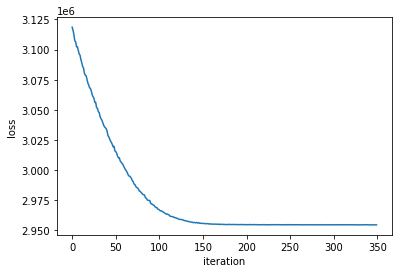

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 2232.6013522887197


100%|██████████| 350/350 [01:55<00:00,  3.04it/s]


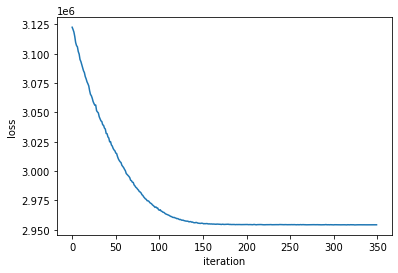

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 3060.5873140868202


100%|██████████| 350/350 [01:57<00:00,  2.98it/s]


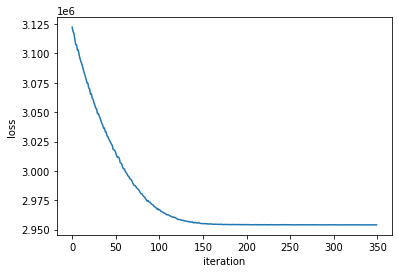

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 1750.3717261091454


100%|██████████| 350/350 [01:57<00:00,  2.98it/s]


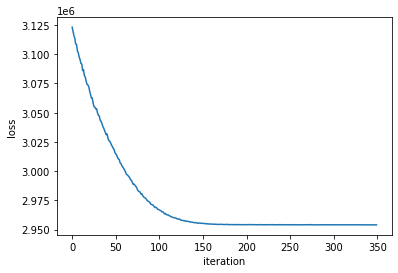

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 1970.2955163881718


100%|██████████| 350/350 [01:56<00:00,  3.00it/s]


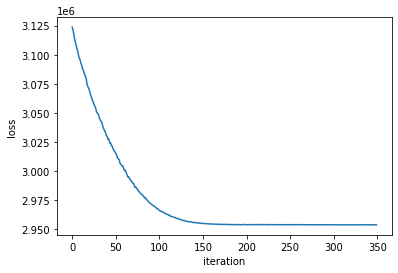

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 2218.8507560194757


 83%|████████▎ | 291/350 [01:36<00:19,  3.03it/s]

In [ ]:
# run the optimization
dcml_outputs = list(dict())
for dcml_init,cluster_assignment in dcml_inits:
    dcml_params, dhist, droots, dharm = infer_posteriors(dcml_obs, dcml_init, dcml_chordtypes, cluster_assignment,
                                                     nsteps=350, subsamples=None, particles=1,
                                                     save_as="dcml_params"+str(nclusters))
    dcml_outputs.append(dict({
        "dcml_params": dcml_params,
        "dhist": dhist,
        "droots": droots,
        "dharm": dharm,
        "cluster_assignment": cluster_assignment
    }))

In [39]:
dcml_outputs[0]['cluster_assignment']

tensor([1, 1, 0, 2, 3, 3, 5, 5, 4, 5, 4, 2, 2, 2])

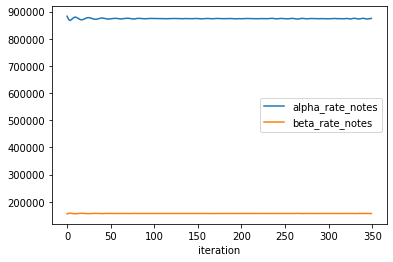

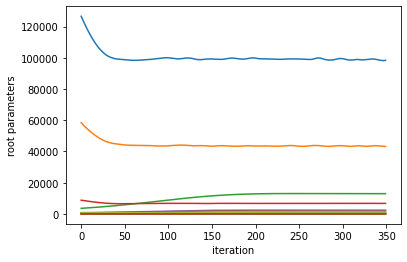

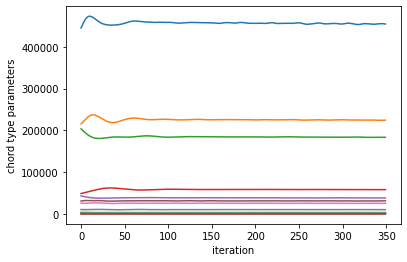

In [51]:
# plot the histories the parameters to check convergence
for output in dcml_outputs:
    plot_histories(output['dhist'], output['droots'], output['dharm'])

874995.0
156846.55


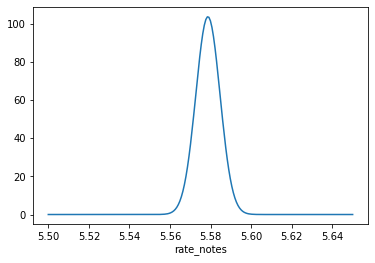

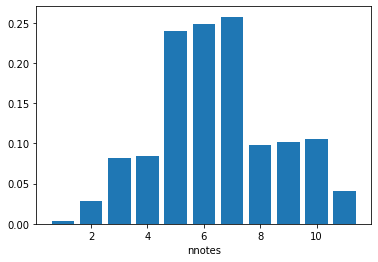

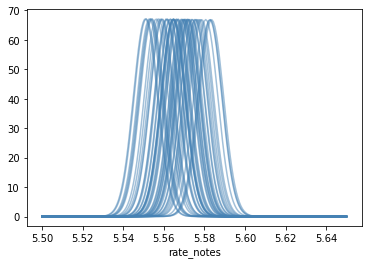

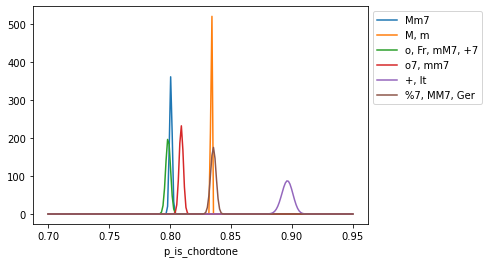

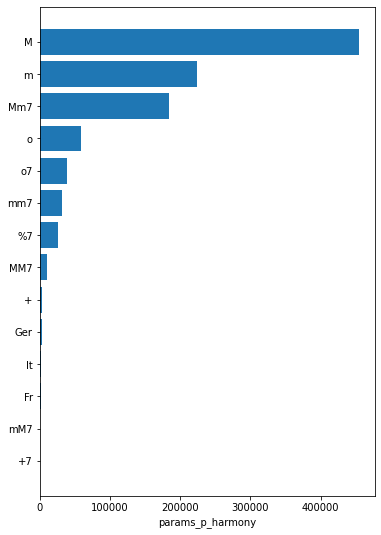

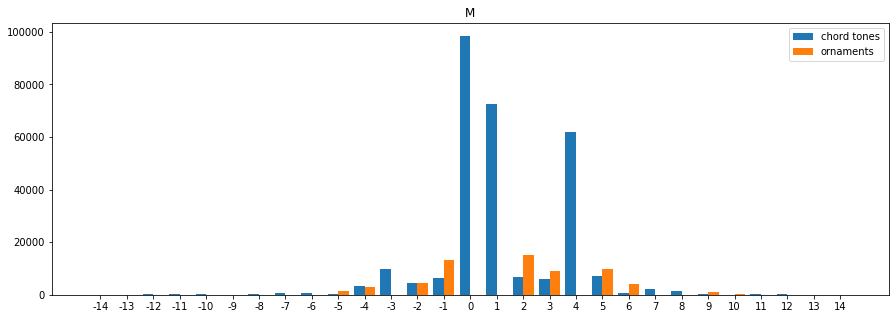

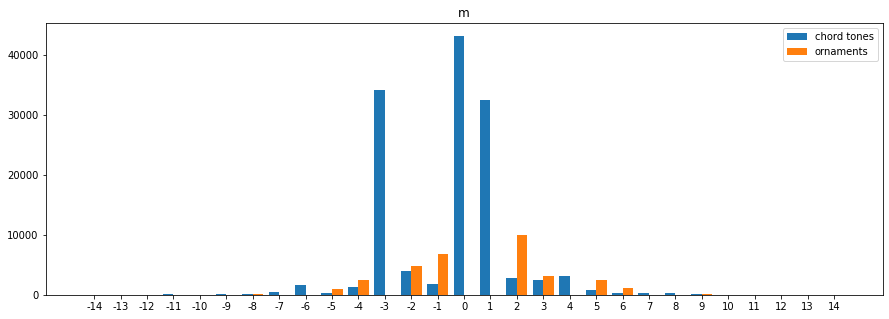

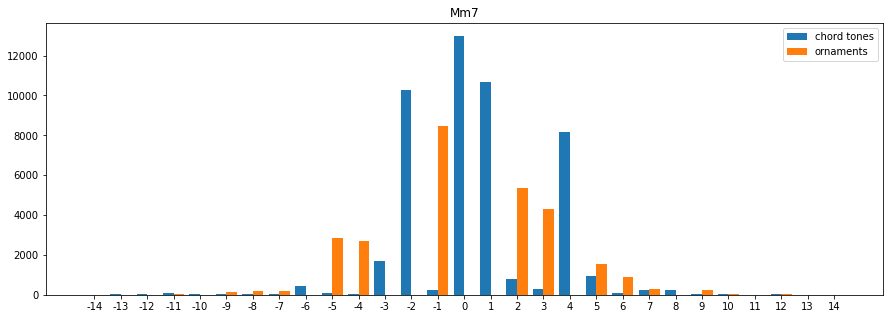

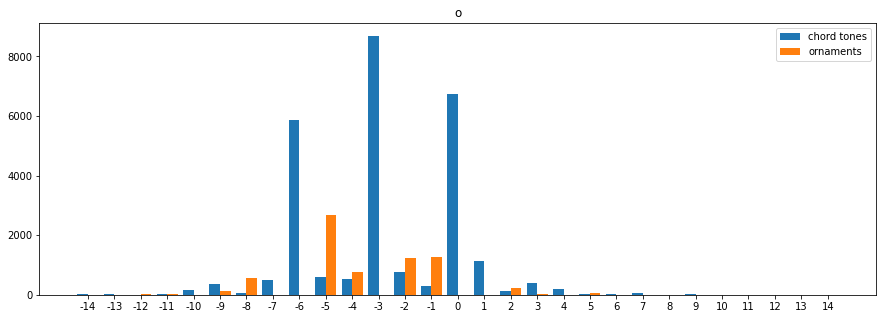

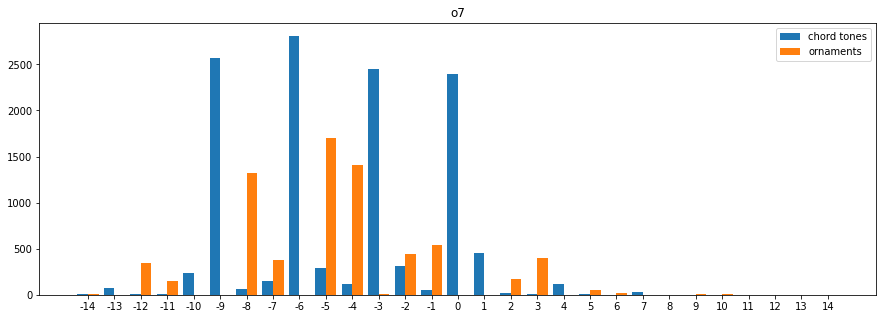

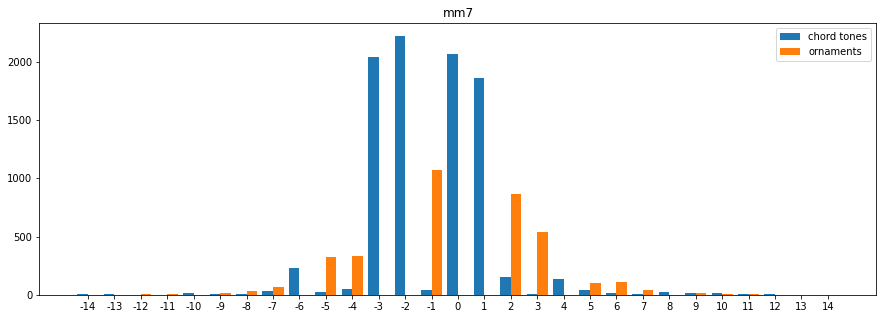

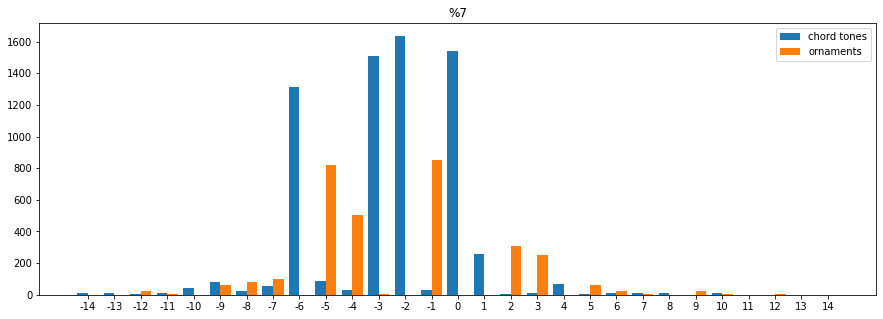

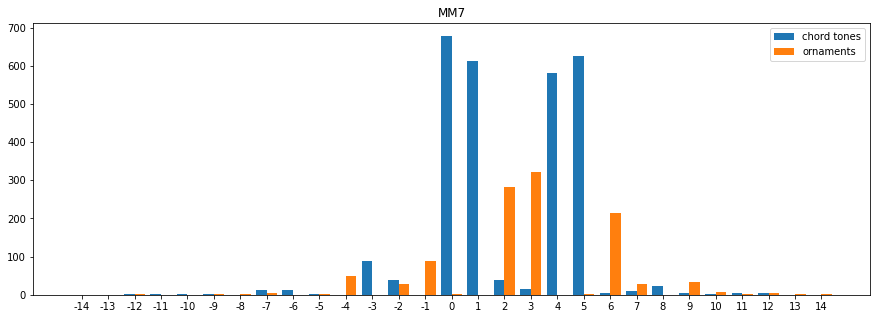

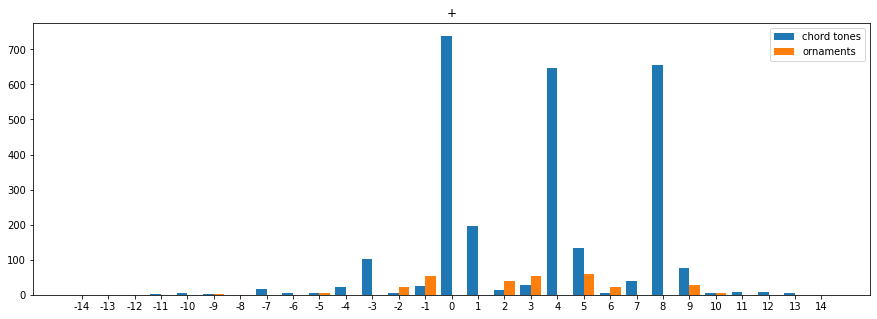

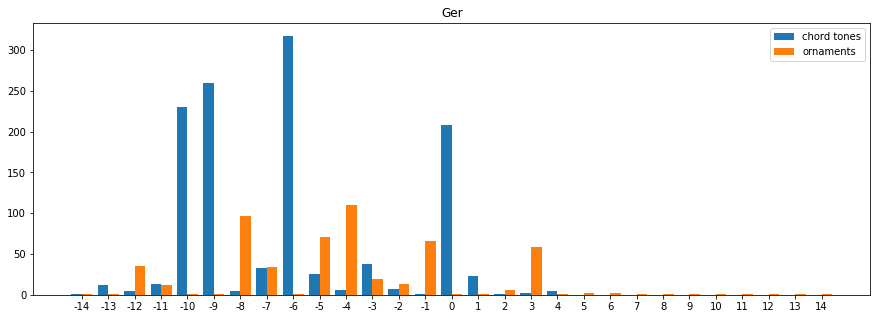

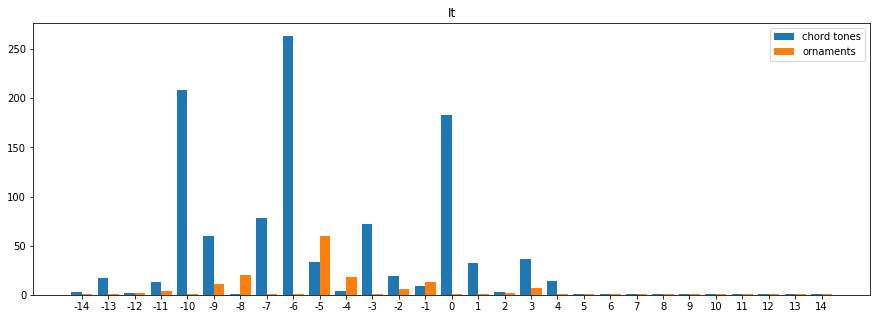

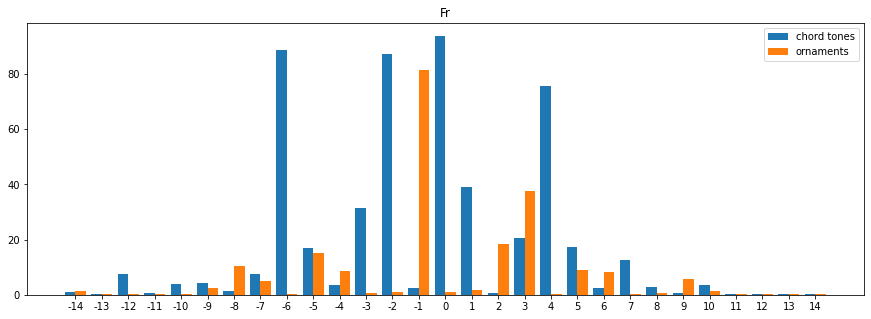

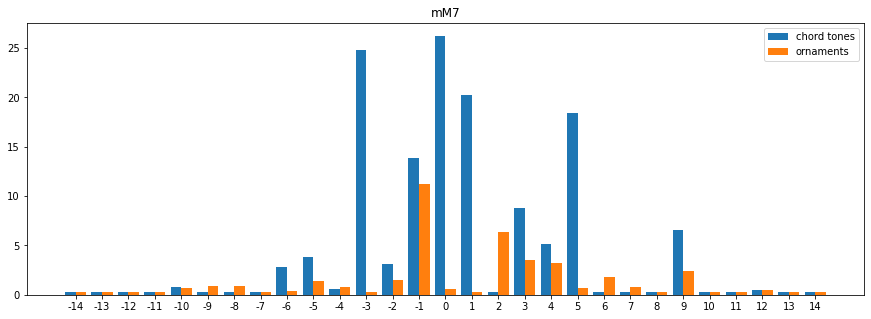

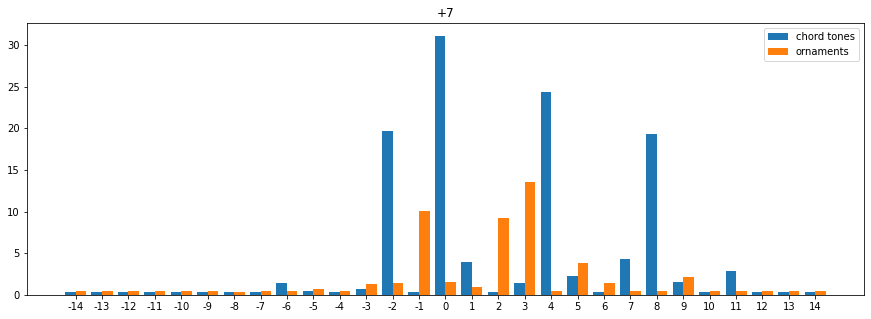

In [52]:
for output in dcml_outputs:
    # plot the posterior distributions of the parameters
    plot_note_rate(output['dcml_params'], lower=5.5, upper=5.65)
    plot_note_rates(output['dhist'], n=50, lower=5.5, upper=5.65)
    plot_p_ict(output['dcml_params'], dcml_chordtypes, output['cluster_assignment'], lower=0.7, upper=0.95)
    plot_chord_type_dist(output['dcml_params'], dcml_chordtypes)
    plot_chords(output['dcml_params'], dcml_chordtypes)

### Wikifonia Corpus

The Wikifonia dataset consists of leadsheets, i.e. melodies and chord labels.
It uses the chord types set in the MusicXML source of the chord-labels, which can be quite chaotic.
Therefore, we normalize the chord-types to the ones defined in the MusicXML standard,
removing unclear chord labels (which are rather rare).

In [138]:
# prepare the dataset
wiki_df, wiki_obs, wiki_chordtypes = load_dataset('data/wikifonia.tsv')
wiki_inits = [get_init_params(wiki_df, len(wiki_chordtypes), npcs, nclusters, mean_dist) for nclusters in range(1,15)]
#wiki_inits = list(map(lambda nclusters: get_init_params(wiki_df, len(wiki_chordtypes), npcs, nclusters), range(1,25)))
#ist(map(lambda wiki_init: wiki_init['harmonies'].int(), wiki_inits))

loading dataset...
using precomputed tensor data.
24 chord types
257625 chords


[tensor([339087, 220639, 119740,  79974,  31183,  16626,  16125,   8813,   7902,
           5700,   5345,   4306,   3809,   3082,   2812,   2604,   2206,   1048,
            841,    805,    622,    517,    149,     30], dtype=torch.int32),
 tensor([339087, 220639, 119740,  79974,  31183,  16626,  16125,   8813,   7902,
           5700,   5345,   4306,   3809,   3082,   2812,   2604,   2206,   1048,
            841,    805,    622,    517,    149,     30], dtype=torch.int32),
 tensor([339087, 220639, 119740,  79974,  31183,  16626,  16125,   8813,   7902,
           5700,   5345,   4306,   3809,   3082,   2812,   2604,   2206,   1048,
            841,    805,    622,    517,    149,     30], dtype=torch.int32),
 tensor([339087, 220639, 119740,  79974,  31183,  16626,  16125,   8813,   7902,
           5700,   5345,   4306,   3809,   3082,   2812,   2604,   2206,   1048,
            841,    805,    622,    517,    149,     30], dtype=torch.int32),
 tensor([339087, 220639, 119740,  79974,

In [139]:
print(wiki_chordtypes)
#for init in wiki_inits:
    #print(init['cluster'])

['major', 'dominant', 'minor', 'minor-seventh', 'major-seventh', 'dominant-ninth', 'major-sixth', 'diminished', 'minor-sixth', 'half-diminished', 'suspended-fourth', 'diminished-seventh', 'augmented-seventh', 'augmented', 'dominant-13th', 'minor-ninth', 'major-ninth', 'dominant-11th', 'major-minor', 'power', 'suspended-second', 'minor-11th', 'major-13th', 'minor-13th']
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[0.2771, 0.7229],
        [0.3743, 0.6257],
        [0.2790, 0.7210],
        [0.2413, 0.7587],
        [0.2727, 0.7273],
        [0.2188, 0.7812],
        [0.2240, 0.7760],
        [0.0789, 0.9211],
        [0.2681, 0.7319],
        [0.2283, 0.7717],
        [0.2258, 0.7742],
     

100%|██████████| 350/350 [02:40<00:00,  2.18it/s]


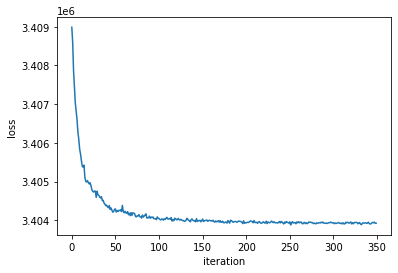

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 266.77594920011757


100%|██████████| 350/350 [02:41<00:00,  2.17it/s]


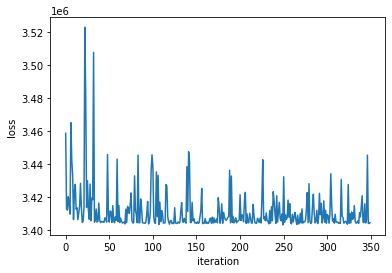

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 58877626.60800596


100%|██████████| 350/350 [02:40<00:00,  2.18it/s]


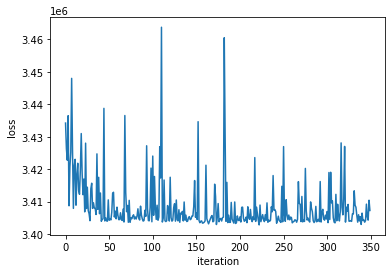

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 25205804.132273916


100%|██████████| 350/350 [02:40<00:00,  2.19it/s]


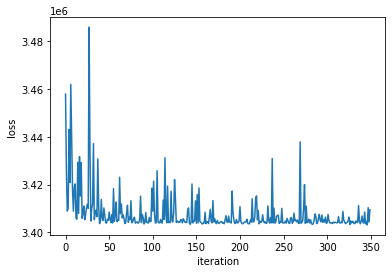

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 15842299.561341379


100%|██████████| 350/350 [02:40<00:00,  2.18it/s]


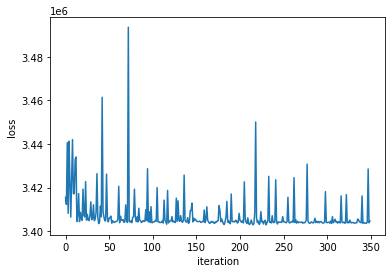

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 23431677.8720009


100%|██████████| 350/350 [02:49<00:00,  2.07it/s]


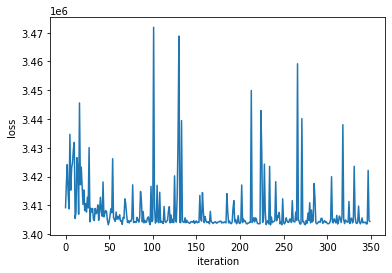

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 62892333.80390667


100%|██████████| 350/350 [02:45<00:00,  2.11it/s]


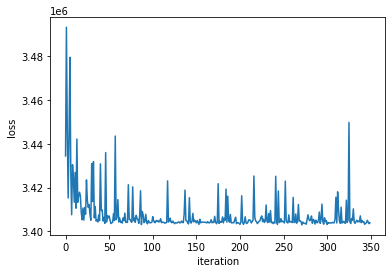

  0%|          | 0/350 [00:00<?, ?it/s]

loss variance (last 100 steps): 30437121.602534976


 95%|█████████▌| 334/350 [02:39<00:07,  2.09it/s]


KeyboardInterrupt: 

In [140]:
# run the optimization
wiki_outputs = list(dict())
for wiki_init, cluster_assignment in wiki_inits:
    wiki_params, whist, wroots, wharm = infer_posteriors(wiki_obs, wiki_init, wiki_chordtypes, cluster_assignment,
                                                     nsteps=350, subsamples=None, particles=1,
                                                     save_as="wikifonia_params"+str(i))    
    wiki_outputs.append(dict({
        "wiki_params": wiki_params,
        "whist": whist,
        "wroots": wroots,
        "wharm": wharm,
        "cluster_assignment": cluster_assignment
    }))


In [ ]:
# plot the histories the parameters to check convergence
for output in wiki_outputs:
    plot_histories(output['whist'], output['wroots'], output['wharm'])
#plot_histories(whist, wroots, wharm)

In [ ]:
# plot the posterior distributions of the parameters
for output in wiki_outputs:
    # plot the posterior distributions of the parameters
    plot_note_rate(output['wiki_params'], lower=2.35, upper=2.45)
    plot_note_rates(output['whist'], n=50, lower=2.35, upper=2.45)
    plot_p_ict(output['wiki_params'], wiki_chordtypes, lower=0.65, upper=0.95)
    plot_chord_type_dist(output['wiki_params'], wiki_chordtypes)
    plot_chords(output['wiki_params'], wiki_chordtypes)
#plot_note_rate(wiki_params, lower=2.35, upper=2.45)
#plot_note_rates(whist, n=100, lower=2.35, upper=2.45)
#plot_p_ict(wiki_params, wiki_chordtypes, lower=0.65, upper=0.95)
#plot_chord_type_dist(wiki_params, wiki_chordtypes)
#plot_chords(wiki_params, wiki_chordtypes)

In [ ]:
len(wiki_inits)

In [63]:
wiki_outputs[0]['wiki_params']['params_cluster']

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [64]:
wiki_inits[5]['cluster']

tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])

In [65]:
dcml_outputs[0]['dcml_params']['params_cluster']

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [66]:
dcml_inits[5]['cluster']

tensor([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]])

In [70]:
dcml_inits[5]['is_ct']


tensor([ 81484, 525903,  33999,  35104,   4204,  17981])

In [69]:
dcml_inits[5]['is_or']

tensor([35023, 99203,  7885, 12220,   446,  5431])

In [71]:
dcml_outputs[0]['dcml_params']['alpha_p_ict']

array([106723.664 , 512091.88  ,  33093.527 ,  42657.375 ,   3920.8176,
        22260.277 ], dtype=float32)

In [72]:
dcml_outputs[0]['dcml_params']['beta_p_ict']

array([ 26743.66   , 101960.52   ,   8103.1846 ,  10061.636  ,
          478.05414,   4394.7773 ], dtype=float32)

In [74]:
stats.beta.mean(dcml_inits[5]['is_ct'][0],dcml_inits[5]['is_or'][0])

0.6993914528740762

In [75]:
stats.beta.mean(dcml_inits[5]['is_ct'][1],dcml_inits[5]['is_or'][1])

0.8413021151612686

In [76]:
stats.beta.mean(dcml_inits[5]['is_ct'][5],dcml_inits[5]['is_or'][5])

0.7680249444729199

In [78]:
stats.beta.mean(dcml_outputs[0]['dcml_params']['alpha_p_ict'][5],dcml_outputs[0]['dcml_params']['beta_p_ict'][5])

0.8351240754127502

In [79]:
stats.beta.mean(dcml_outputs[0]['dcml_params']['alpha_p_ict'][1],dcml_outputs[0]['dcml_params']['beta_p_ict'][1])

0.8339546918869019

In [80]:
stats.beta.mean(dcml_inits[13]['is_ct'][6],dcml_inits[13]['is_or'][6])

0.7688750862663906

In [81]:
stats.beta.mean(dcml_inits[13]['is_ct'][7],dcml_inits[13]['is_or'][7])

0.7599745668415196

In [82]:
stats.beta.mean(dcml_inits[13]['is_ct'][9],dcml_inits[13]['is_or'][9])

0.7825921702774611

In [83]:
stats.beta.mean(dcml_inits[13]['is_ct'][0],dcml_inits[13]['is_or'][0])

0.8435364147318993

In [84]:
stats.beta.mean(dcml_inits[13]['is_ct'][1],dcml_inits[13]['is_or'][1])

0.8366709923514029